In [2]:
import pandas as pd
import numpy as np
import tensorflow.keras.layers
from keras.src.layers import Lambda
from matplotlib import pyplot as plt
import tensorflow as tf
import math
import ydf  # Yggdrasil Decision Forests
from sklearn.model_selection import train_test_split
from wurlitzer import sys_pipes
import keras.layers as preprocessing
from sklearn.model_selection import KFold
import tqdm as tqdm
from sklearn.preprocessing import MinMaxScaler


%matplotlib inline
plt.rcParams['figure.figsize'] = [16, 10]

2025-03-29 09:22:32.812626: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1743254552.823916 3481681 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1743254552.827485 3481681 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1743254552.837186 3481681 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1743254552.837194 3481681 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1743254552.837196 3481681 computation_placer.cc:177] computation placer alr

In [3]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Set memory growth to avoid TensorFlow using all GPU memory
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)

        # Set TensorFlow to use only the first GPU (if multiple GPUs available)
        tf.config.experimental.set_visible_devices(gpus[0], 'GPU')

        print("Using GPU:", gpus[0])
    except RuntimeError as e:
        print(e)

Using GPU: PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')


In [4]:
def train_and_eval(model, train_ds, test_ds = None):
    # Optionally, add evaluation metrics.
    model.compile(metrics=["mse"])
    rmse = 0

    with sys_pipes():
        model.fit(x=train_ds)

    if test_ds is not None:
        evaluation = model.evaluate(x=test_ds, return_dict=True)
        rmse = math.sqrt(evaluation["mse"])

    return rmse

def latlon_to_xyz(lat, lon):
    lat, lon = np.radians(lat), np.radians(lon)
    x = np.cos(lat) * np.cos(lon)
    y = np.cos(lat) * np.sin(lon)
    z = np.sin(lat)
    return x, y, z

# Example: Normalize Cartesian coordinates between 0 and 1
def normalize_xyz(x, y, z):
    # Normalizing each coordinate to the [0, 1] range
    return (x + 1) / 2, (y + 1) / 2, (z + 1) / 2

In [109]:
ROOT_DIR = "temporary"
train_df = pd.read_csv(f'{ROOT_DIR}/Train.csv')
test_df = pd.read_csv(f'{ROOT_DIR}/Test.csv')
vocab_df = pd.read_csv(f'{ROOT_DIR}/variable_descriptions.csv')
admin_df = pd.read_csv(f'{ROOT_DIR}/zaf_adminboundaries_tabulardata.csv', sep=";")

admin_df = admin_df[["ADM4_PCODE", "AREA_SQKM", "ADM2_ID", "ADM3_ID"]] # ADM3_ID
admin_df["AREA_SQKM"] = admin_df["AREA_SQKM"].str.replace(",", ".").astype(float)
train_df = pd.merge(train_df, admin_df, on="ADM4_PCODE", how="left")
test_df = pd.merge(test_df, admin_df, on="ADM4_PCODE", how="left")
label_column = "target"

default_columns = ["ward", "ADM4_PCODE"]
nul_cols = ["dw_12", "dw_13", "lan_13", "pw_08", "pw_07"] # Columns with null values
cat_columns = ["ADM2_ID"] # Categorical columns
ft_columns = default_columns + cat_columns

Let's do some EDA. How our data describe poverty levels of women in South Africa?

About the data:
- We know from previous analysis that there are some columns with null values. We will remove them.
- We also add new columns from the admin_df dataframe. We add the area of the region and the second administrative level id. We use the second administrative level because it has a less granular level of detail than the fourth administrative level and the number of unique values is reasonable.

In [91]:
eda_df = train_df.copy()
eda_df.drop(nul_cols, axis=1, inplace=True)
eda_df.head()

,ward,total_households,total_individuals,target,dw_00,dw_01,dw_02,dw_03,dw_04,dw_05,...,pw_04,pw_05,pw_06,ADM4_PCODE,lat,lon,NL,AREA_SQKM,ADM2_ID,ADM3_ID
0,41601001: Ward 1,1674.45058,5888.20750,16.773757,0.933841,0.000846,0.005490,0.000676,0.000000,0.001372,...,0.007537,0.000000,0.012928,ZA4161001,-29.682270,24.734743,0.292039,3011.644116,DC16,FS161
1,41601002: Ward 2,1736.99230,6735.33812,21.496661,0.696940,0.001253,0.004402,0.000000,0.002301,0.001323,...,0.057127,0.019092,0.004131,ZA4161002,-29.119311,24.757737,3.207775,5.411509,DC16,FS161
2,41601003: Ward 3,2403.57591,7273.04995,10.931425,0.810545,0.004517,0.008891,0.003986,0.007735,0.000956,...,0.010358,0.001421,0.040881,ZA4161003,-29.142276,25.094093,0.000000,4938.103494,DC16,FS161
3,41601004: Ward 4,1740.78737,5734.49046,23.119257,0.659914,0.000000,0.006129,0.000000,0.000813,0.037245,...,0.000669,0.000000,0.005011,ZA4161004,-29.372052,24.942867,2.038778,172.457883,DC16,FS161
4,41601005: Ward 5,1730.51451,6657.23835,13.652252,0.950575,0.000655,0.001473,0.000598,0.006999,0.000818,...,0.001290,0.000673,0.017629,ZA4161005,-29.409381,25.290165,0.000000,1686.379535,DC16,FS161


In [8]:
eda_df.describe()

,total_households,total_individuals,target,dw_00,dw_01,dw_02,dw_03,dw_04,dw_05,dw_06,...,pw_01,pw_02,pw_03,pw_04,pw_05,pw_06,lat,lon,NL,AREA_SQKM
count,2822.000000,2822.000000,2822.000000,2822.000000,2822.000000,2822.000000,2822.000000,2822.000000,2822.000000,2822.000000,...,2822.000000,2822.000000,2822.000000,2822.000000,2822.000000,2822.000000,2822.000000,2822.000000,2822.000000,2822.000000
mean,3665.281214,12869.130053,24.507554,0.712196,0.092616,0.032043,0.006057,0.008665,0.006289,0.022375,...,0.329684,0.127555,0.041589,0.019655,0.011008,0.110818,-26.880740,28.666515,17.437560,276.073658
std,3266.364522,9696.690518,10.294387,0.214035,0.182852,0.080253,0.019374,0.030697,0.024606,0.037127,...,0.236642,0.156400,0.057331,0.032926,0.023672,0.185401,2.021279,2.373809,18.958621,1136.541768
min,1.000000,402.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-32.490089,16.760022,0.000000,0.227161
25%,1778.858235,7071.205695,16.751556,0.594212,0.002895,0.002407,0.000000,0.000000,0.000000,0.002716,...,0.111282,0.008673,0.002099,0.000715,0.000159,0.005217,-28.569019,27.707932,3.033397,5.498194
50%,2398.249935,9366.989680,24.156670,0.766841,0.010425,0.005762,0.000807,0.000607,0.000865,0.008639,...,0.302130,0.069065,0.016496,0.005164,0.001459,0.025165,-26.549866,28.959679,9.205572,29.294864
75%,3987.080563,14241.233015,32.226553,0.881708,0.068209,0.027913,0.002538,0.002225,0.003027,0.025218,...,0.508771,0.183384,0.058626,0.025055,0.009432,0.116638,-25.572130,30.441505,26.890531,121.885114
max,39684.942130,91716.746370,55.528423,0.994962,0.931490,0.951806,0.264239,0.392085,0.435912,0.412936,...,0.937595,1.000000,0.327393,0.306787,0.228261,0.961523,-22.331267,32.858249,63.000000,27812.250650


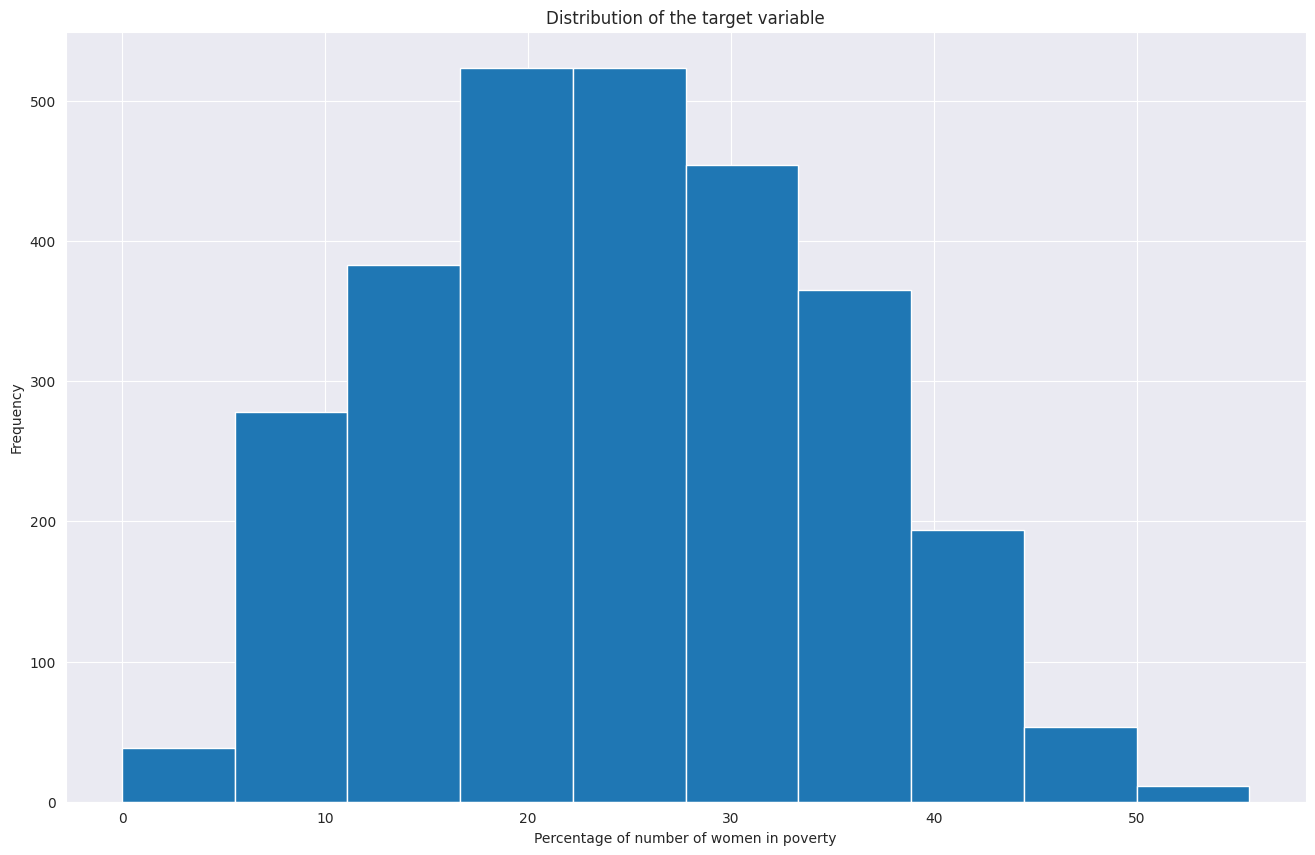

In [10]:
## Let's see the distribution of the target variable
eda_df["target"].hist()
plt.title("Distribution of the target variable")
plt.xlabel("Percentage of number of women in poverty")
plt.ylabel("Frequency")
plt.show()


We can see that most of ward has 20-30% of their women living in poverty. There are no ward with more than 60% of them.

In [13]:
## Let's plot some pairs of features
import seaborn as sns

num_cols = [col for col in eda_df.columns if eda_df[col].dtype == "float64"]
sns.pairplot(eda_df)
plt.show()

KeyboardInterrupt: 

Error in callback <function _draw_all_if_interactive at 0x7212a95d5ee0> (for post_execute), with arguments args (),kwargs {}:


KeyboardInterrupt: 

Error in callback <function flush_figures at 0x72115e543b00> (for post_execute), with arguments args (),kwargs {}:


KeyboardInterrupt: 

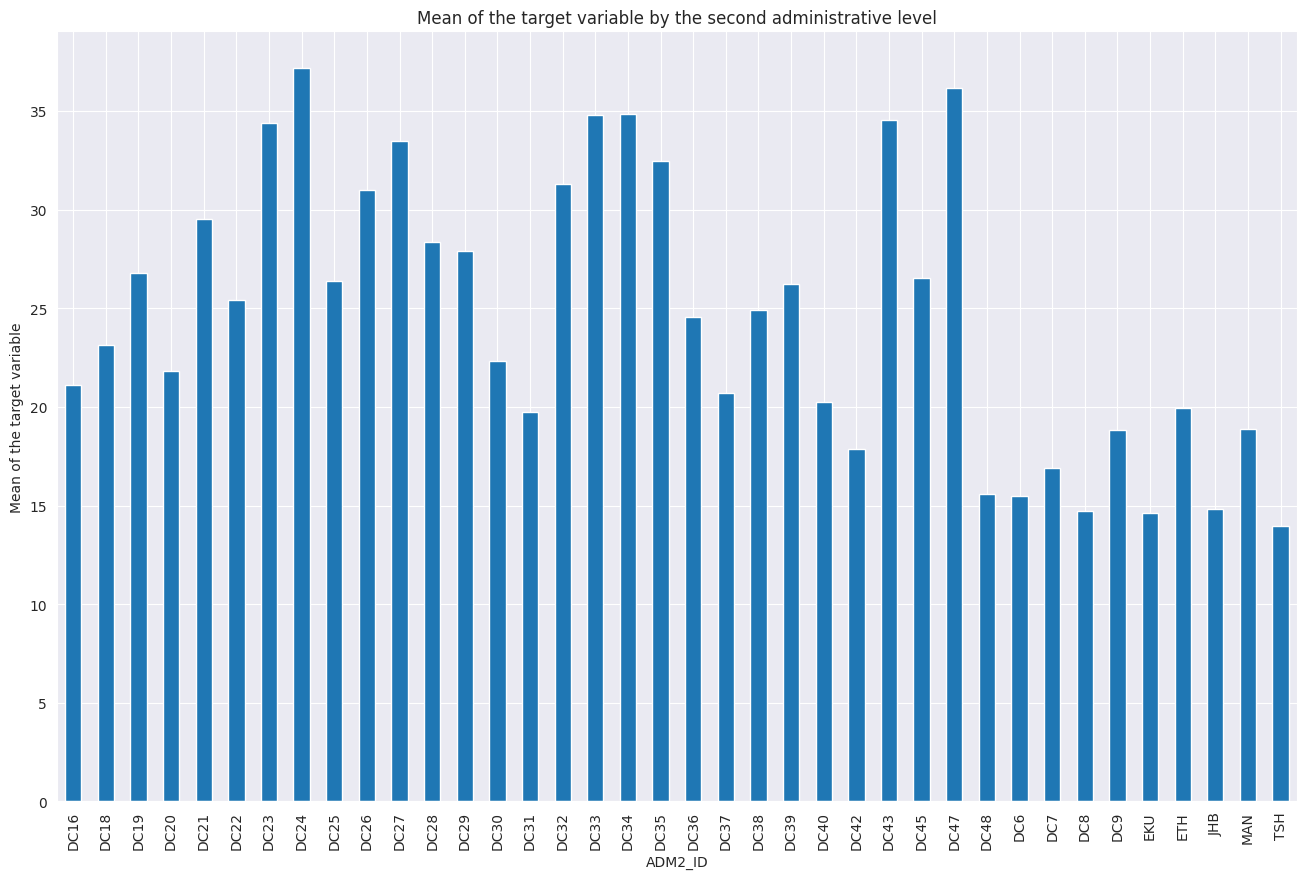

In [14]:
## Let's see the mean of the target variable by the second administrative level
eda_df.groupby("ADM2_ID")["target"].mean().plot(kind="bar")
plt.title("Mean of the target variable by the second administrative level")
plt.xlabel("ADM2_ID")
plt.ylabel("Mean of the target variable")
plt.show()

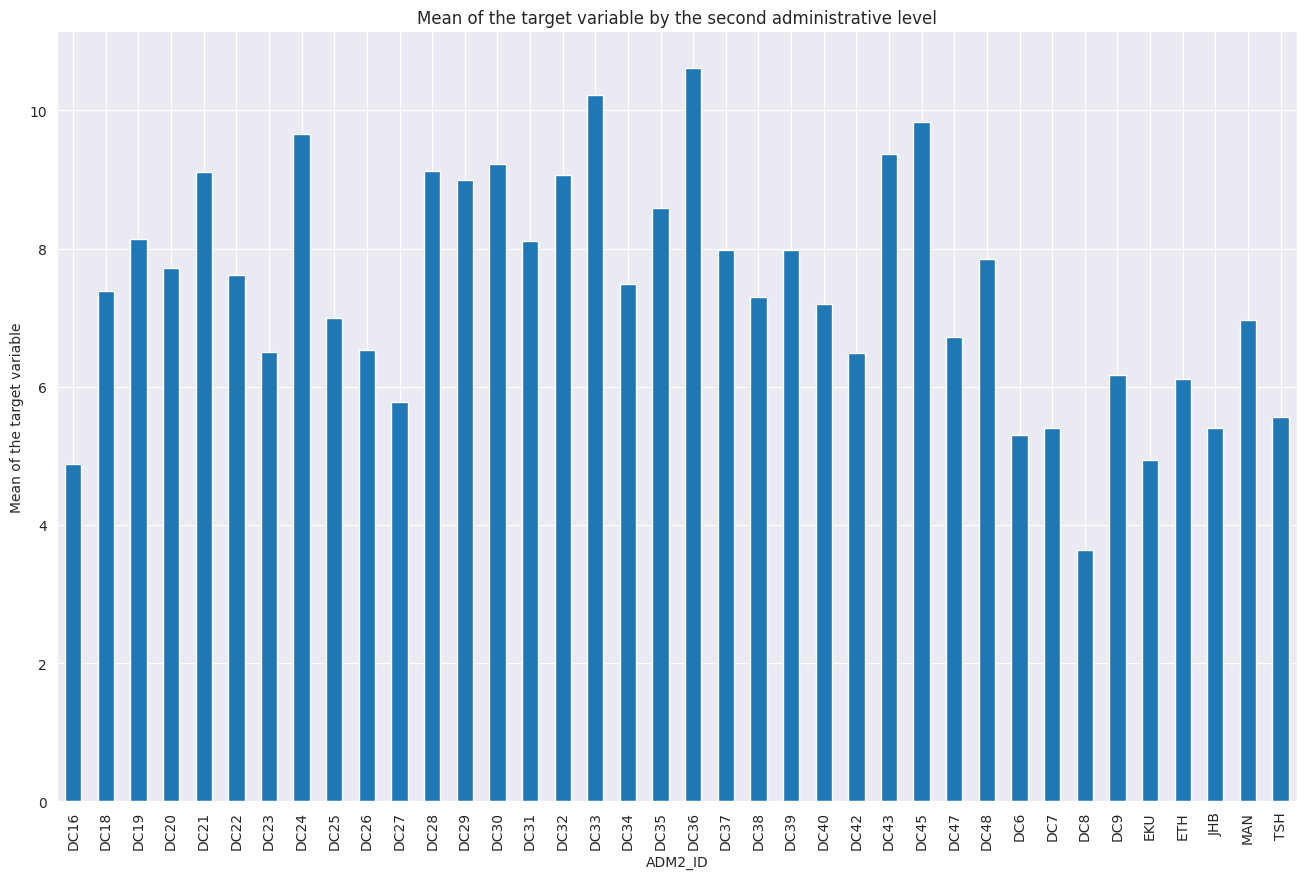

In [15]:
eda_df.groupby("ADM2_ID")["target"].std().plot(kind="bar")
plt.title("Mean of the target variable by the second administrative level")
plt.xlabel("ADM2_ID")
plt.ylabel("Mean of the target variable")
plt.show()

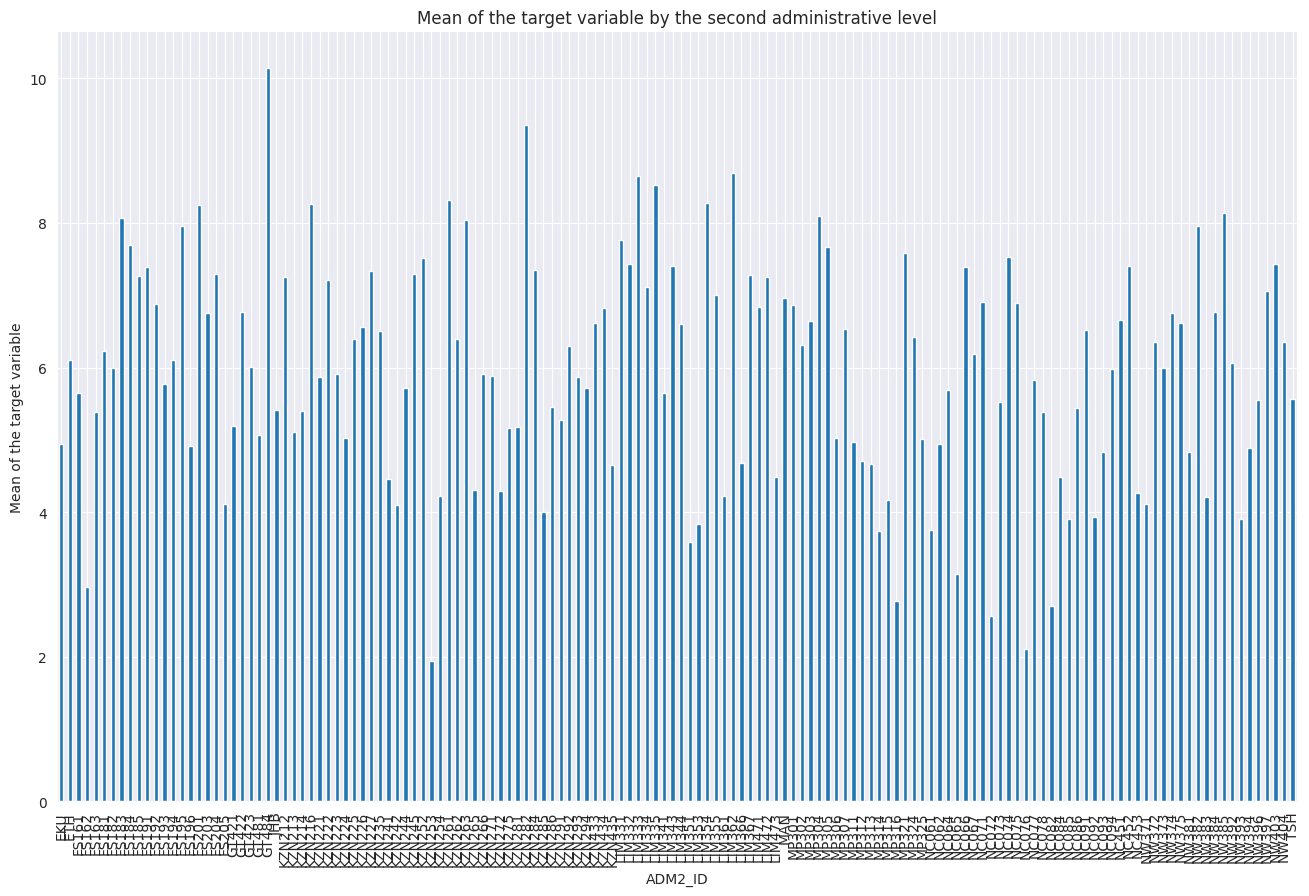

In [19]:
eda_df.groupby("ADM3_ID")["target"].std().plot(kind="bar")
plt.title("Mean of the target variable by the second administrative level")
plt.xlabel("ADM2_ID")
plt.ylabel("Mean of the target variable")
plt.show()

As we can see, the mean of the target variable varies by the second administrative level. But the variance is higher for some regions. On other side, we can see the same pattern for the third administrative level. But the number of unique values is higher than the second administrative level.


In [20]:
## Let's see if there are some ADM2_ID values in the test set that are not in the train set
train_zones = set(train_df["ADM2_ID"].unique())
test_zones = set(test_df["ADM2_ID"].unique())
missing_zones = test_zones - train_zones
missing_zones

{'BUF',
 'CPT',
 'DC1',
 'DC10',
 'DC12',
 'DC13',
 'DC14',
 'DC15',
 'DC2',
 'DC3',
 'DC4',
 'DC44',
 'DC5',
 'NMA'}

We can't use the ADM2_ID as a categorical feature because there are some values in the test set that are not in the train set.

In [21]:
eda_df.columns

Index(['ward', 'total_households', 'total_individuals', 'target', 'dw_00',
       'dw_01', 'dw_02', 'dw_03', 'dw_04', 'dw_05', 'dw_06', 'dw_07', 'dw_08',
       'dw_09', 'dw_10', 'dw_11', 'psa_00', 'psa_01', 'psa_02', 'psa_03',
       'psa_04', 'stv_00', 'stv_01', 'car_00', 'car_01', 'lln_00', 'lln_01',
       'lan_00', 'lan_01', 'lan_02', 'lan_03', 'lan_04', 'lan_05', 'lan_06',
       'lan_07', 'lan_08', 'lan_09', 'lan_10', 'lan_11', 'lan_12', 'lan_14',
       'pg_00', 'pg_01', 'pg_02', 'pg_03', 'pg_04', 'lgt_00', 'pw_00', 'pw_01',
       'pw_02', 'pw_03', 'pw_04', 'pw_05', 'pw_06', 'ADM4_PCODE', 'lat', 'lon',
       'NL', 'AREA_SQKM', 'ADM2_ID', 'ADM3_ID'],
      dtype='object')

There are 10 different attributes:
- Dwelling type
- School attendance,
- Language
- TV
- Car
- Landline ownership
- Population group
- Lighting with electricity
- Water access
- Longitude, Latitude
- Nightlights

We will continue our analysis with the Nightlights vs Light with electricity and Longitude vs Latitude.

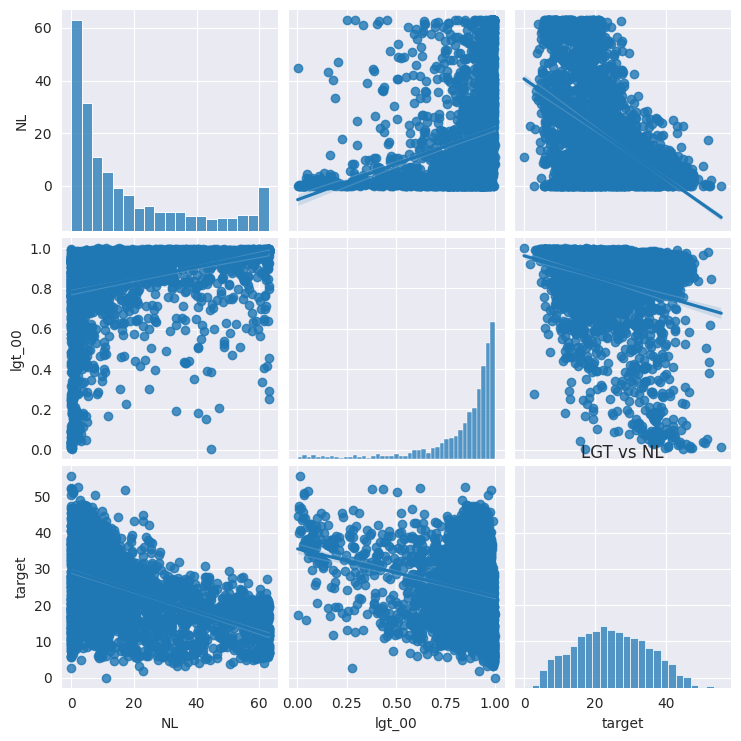

In [23]:
## Let's show a regression plot between the target variable and the features
prefix = "dw_"
cols = ["NL", "lgt_00"]
cols.append("target")
sns.pairplot(eda_df[cols], kind="reg")
plt.title(f"LGT vs NL")
plt.show()

- We can see that there a negative correlation between the target variable and the nightlights. The more nightlights, the less poverty. It makes sense because the nightlights are a proxy for the economic activity in the region.
- Surprisingly, there is not a strong correlation between the NL and the light with electricity. It means that the nightlights are not a good proxy for the light with electricity. It could be that the nightlights are not only from the houses but also from the streets.

For longitude and latitude, we will cluster the regions and see if there are some patterns.

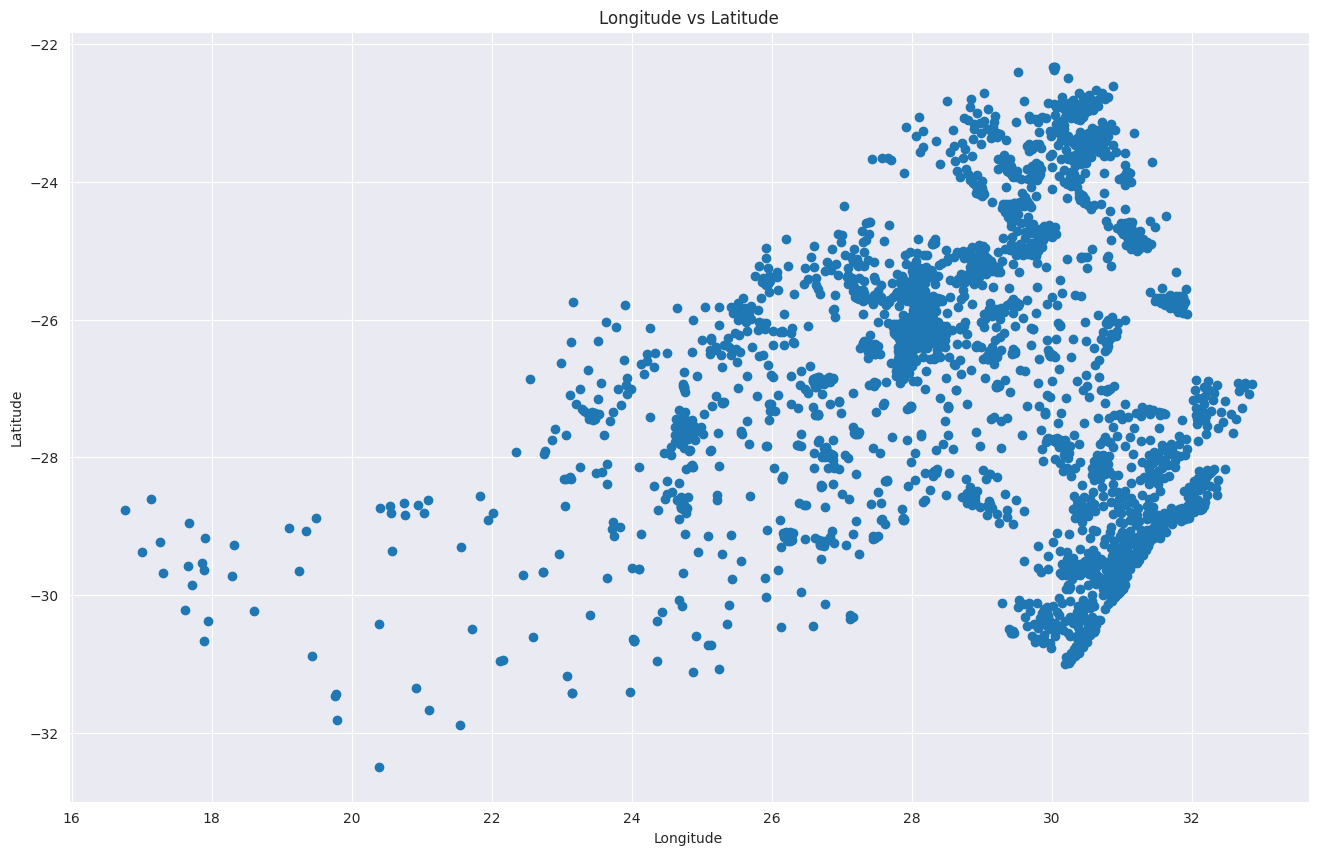

In [24]:
## Let's plot the longitude and latitude
plt.scatter(eda_df["lon"], eda_df["lat"])
plt.title("Longitude vs Latitude")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.show()

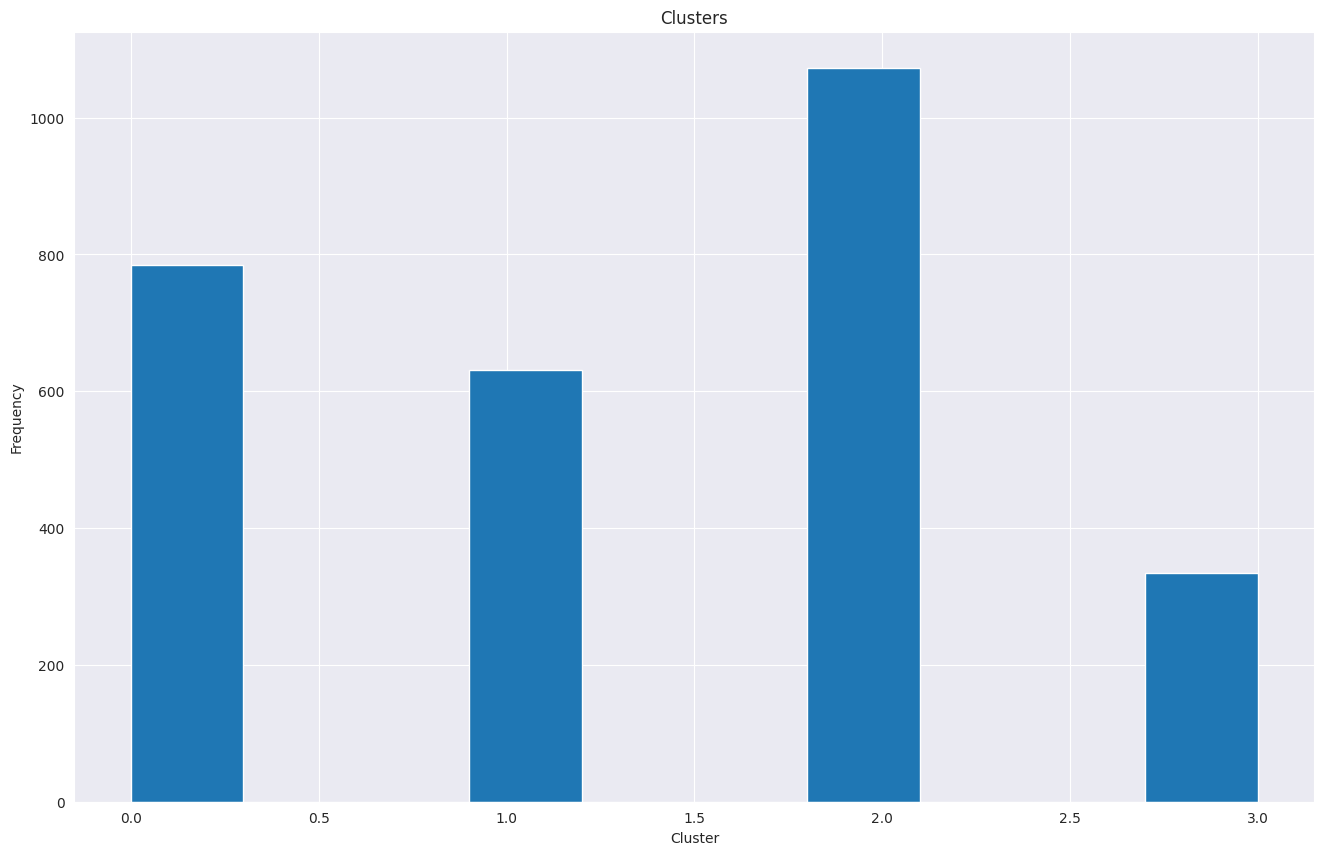

In [39]:
## Let's cluster the regions
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=4, random_state=42)
eda_df["cluster"] = kmeans.fit_predict(eda_df[["lon", "lat"]])
eda_df["cluster"].hist()
plt.title("Clusters")
plt.xlabel("Cluster")
plt.ylabel("Frequency")
plt.show()

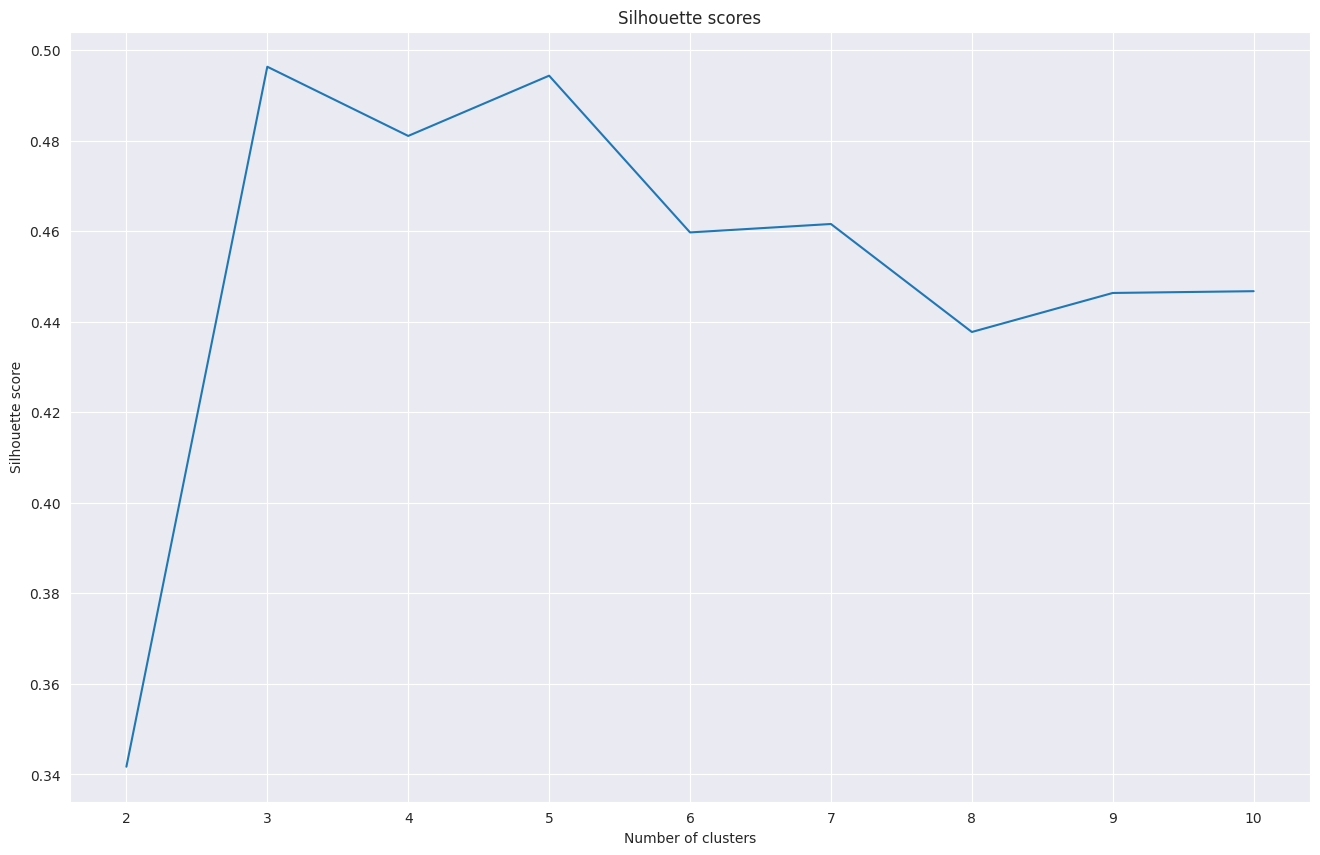

In [38]:
## Let's find the optimal number of clusters
from sklearn.metrics import silhouette_score

silhouette_scores = []
for n_clusters in range(2, 11):
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    cluster_labels = kmeans.fit_predict(eda_df[["lon", "lat"]])
    silhouette_scores.append(silhouette_score(eda_df[["lon", "lat"]], cluster_labels))


plt.plot(range(2, 11), silhouette_scores)
plt.title("Silhouette scores")
plt.xlabel("Number of clusters")
plt.ylabel("Silhouette score")
plt.show()

We can see that the optimal number of clusters is 5. We will continue our analysis with this number of clusters.

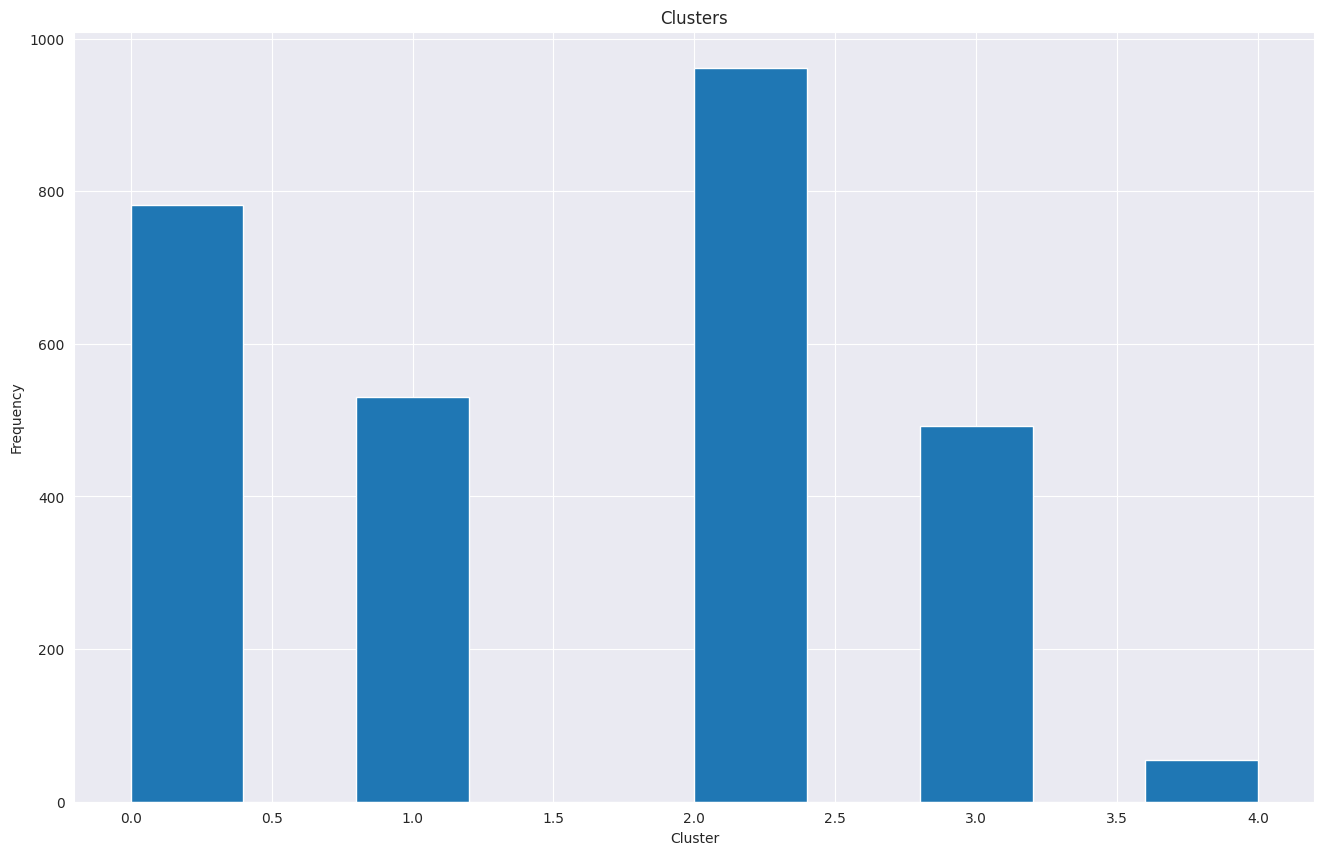

In [92]:
## Let's cluster the regions
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=5, random_state=42)
eda_df["cluster"] = kmeans.fit_predict(eda_df[["lon", "lat"]])
eda_df["cluster"].hist()
plt.title("Clusters")
plt.xlabel("Cluster")
plt.ylabel("Frequency")
plt.show()

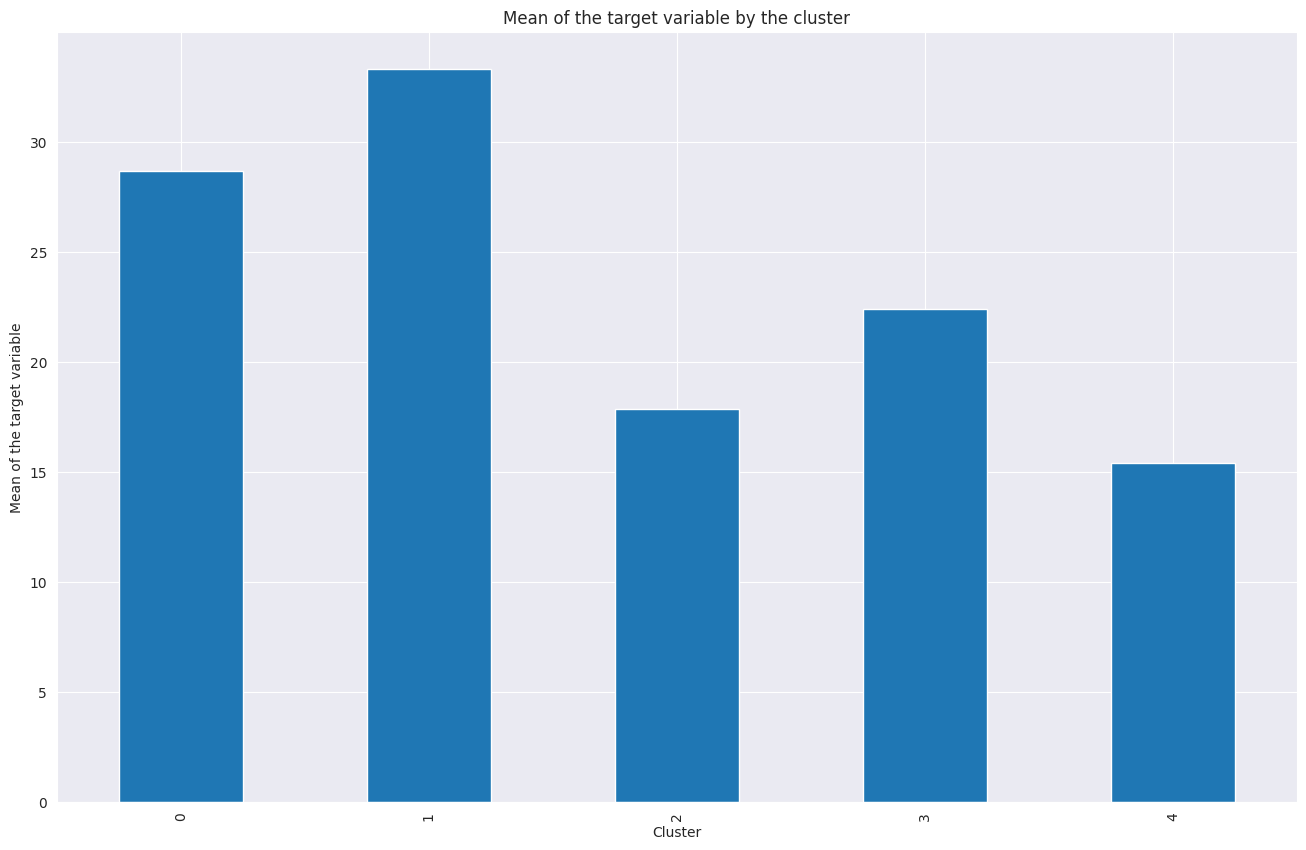

In [51]:
## Let's see the mean of the target variable by the cluster
eda_df.groupby("cluster")["target"].mean().plot(kind="bar")
plt.title("Mean of the target variable by the cluster")
plt.xlabel("Cluster")
plt.ylabel("Mean of the target variable")
plt.show()

We can see that the mean of the target variable varies by the cluster. It means that the location of the region is important to predict the target variable.

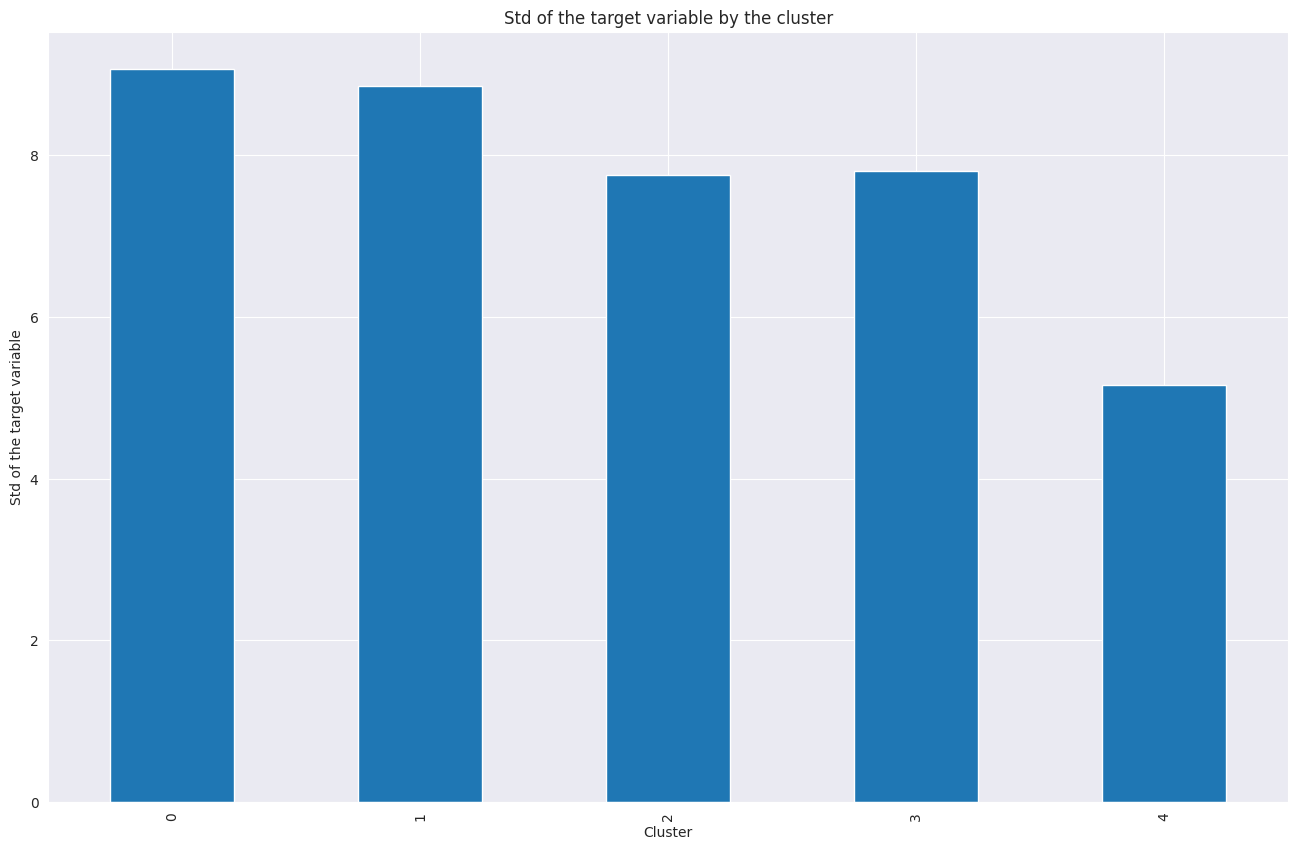

In [52]:
## Let's see the std of the target variable by the cluster
eda_df.groupby("cluster")["target"].std().plot(kind="bar")
plt.title("Std of the target variable by the cluster")
plt.xlabel("Cluster")
plt.ylabel("Std of the target variable")
plt.show()


It seems that the variance of the target variable is higher for some clusters and lower for others. It means that the location of the region could be an important feature to predict the target variable.

Text(0, 0.5, 'Frequency')

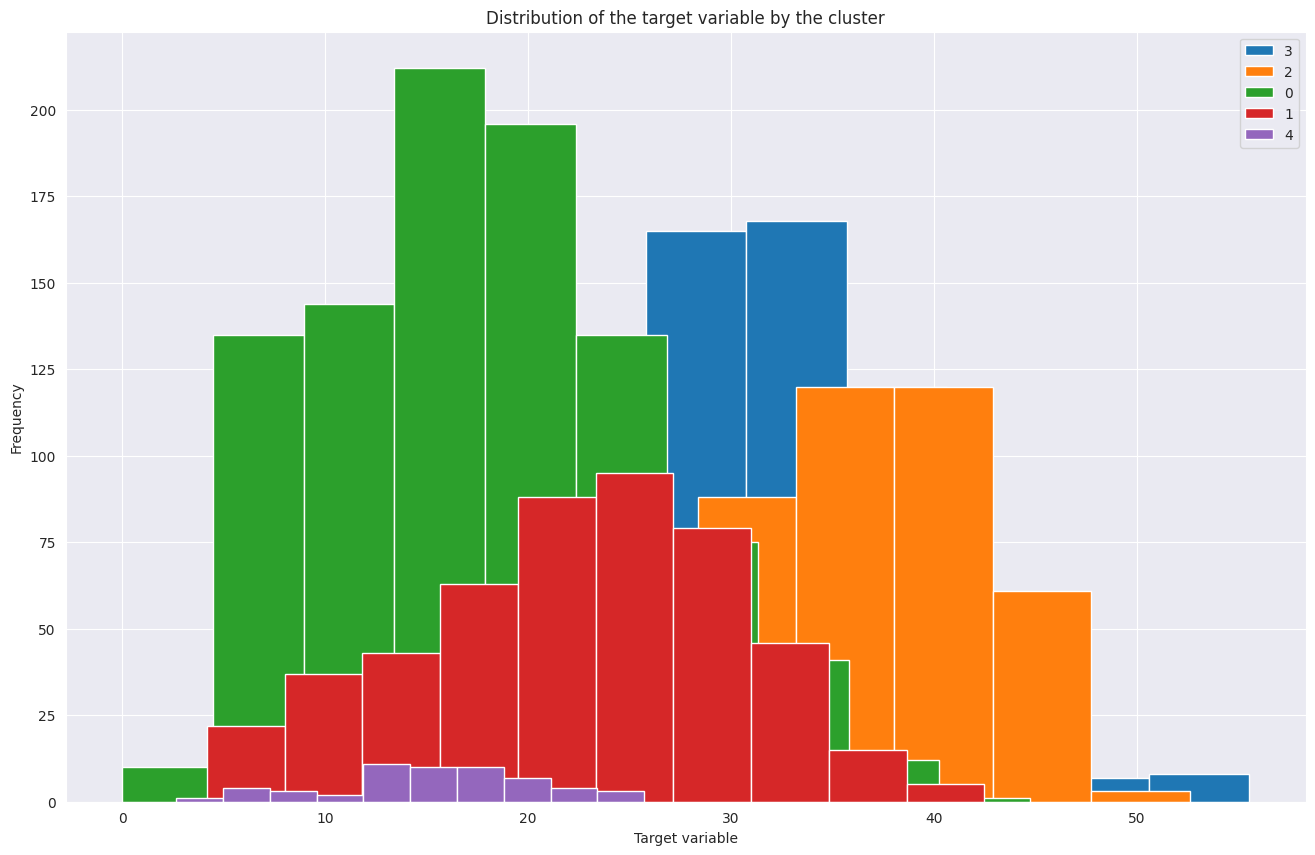

In [53]:
## Let's see the distribution of the target variable by the cluster
eda_df.groupby("cluster")["target"].hist()
plt.legend(eda_df["cluster"].unique())
plt.title("Distribution of the target variable by the cluster")
plt.xlabel("Target variable")
plt.ylabel("Frequency")

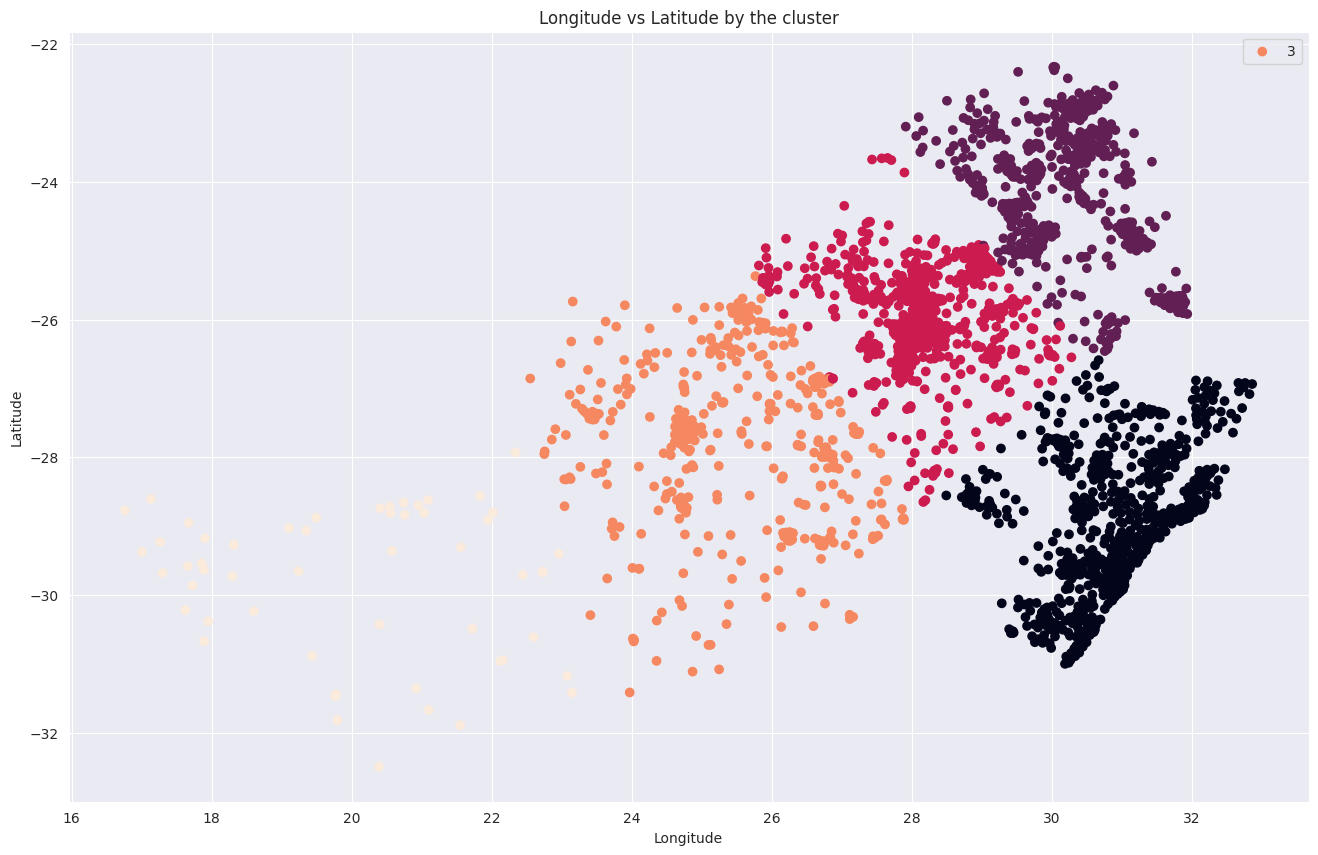

In [55]:
## Let's plot longitude and latitude by the cluster
plt.scatter(eda_df["lon"], eda_df["lat"], c=eda_df["cluster"])
plt.title("Longitude vs Latitude by the cluster")
plt.legend(eda_df["cluster"].unique())
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.show()

We can see that the regions are well clustered by the longitude and latitude. It means that the location of the region is important to predict the target variable.

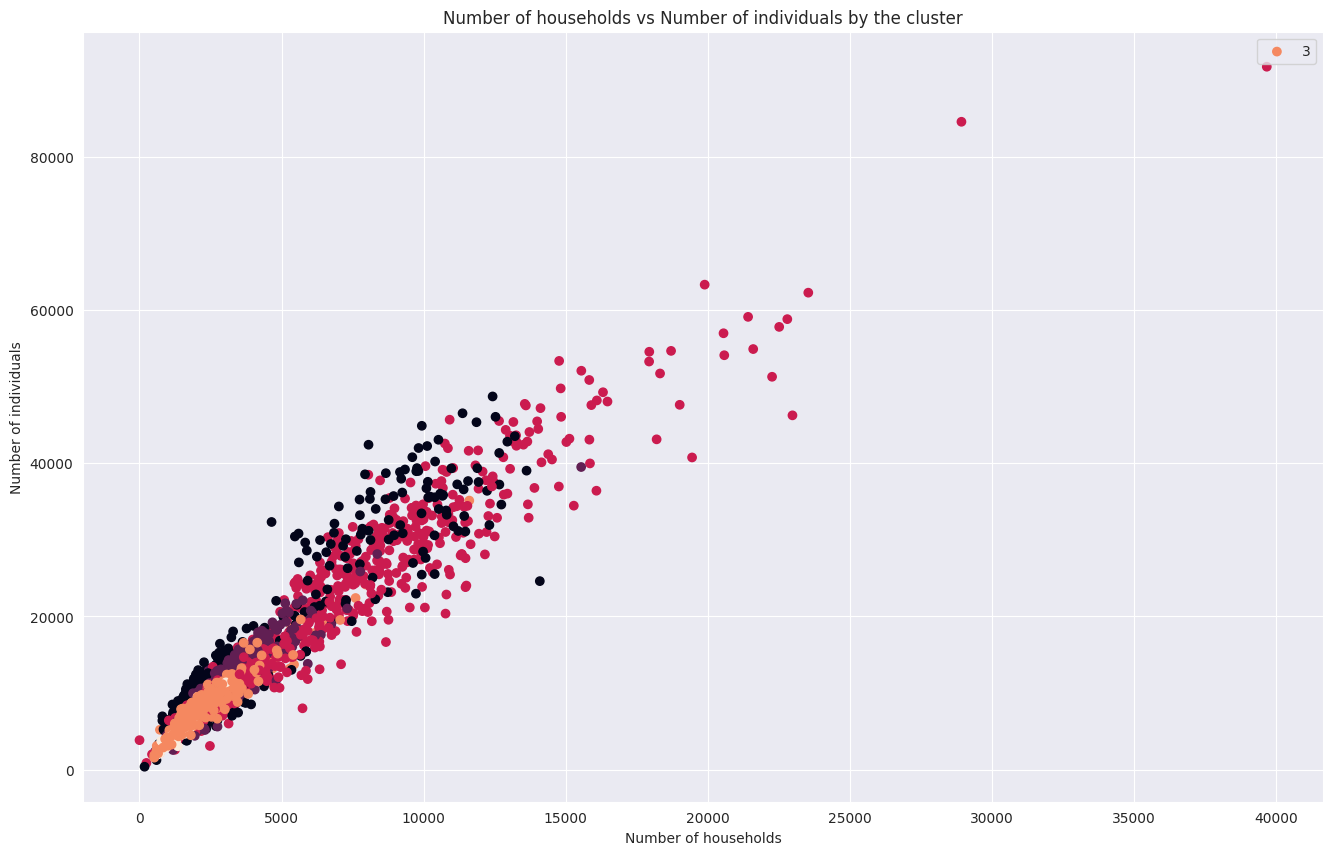

In [56]:
## Let's plot the number of households and the number of individuals by the cluster
plt.scatter(eda_df["total_households"], eda_df["total_individuals"], c=eda_df["cluster"])
plt.title("Number of households vs Number of individuals by the cluster")
plt.legend(eda_df["cluster"].unique())
plt.xlabel("Number of households")
plt.ylabel("Number of individuals")
plt.show()

- We can see that there are a positive correlation between the number of households and the number of individuals. It makes sense because the more households, the more individuals.
- But, the number of households and individuals are not well clustered by the cluster.

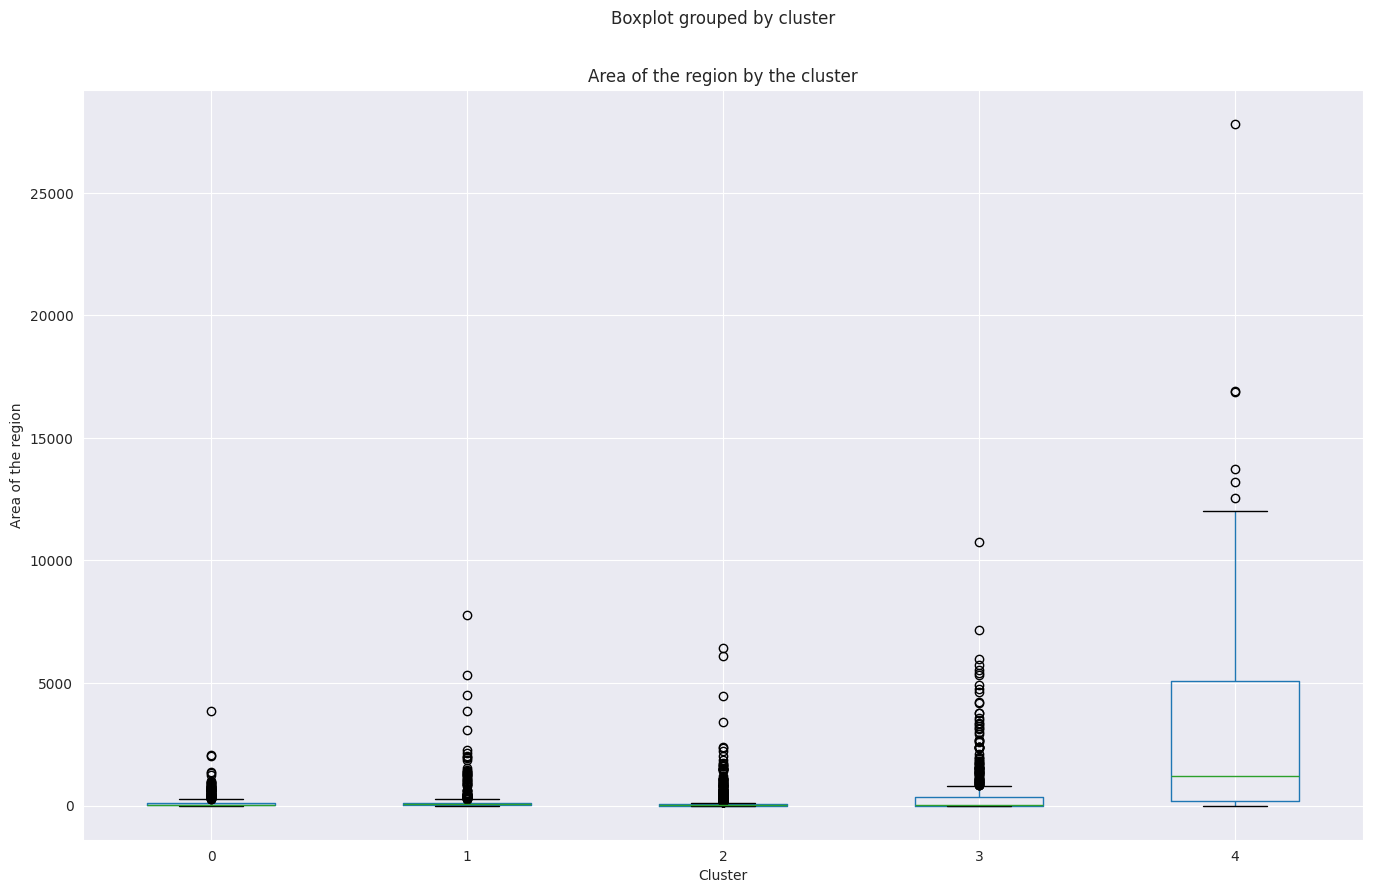

In [60]:
## Let's plot the box plot of the area of the region by the cluster
eda_df.boxplot(column="AREA_SQKM", by="cluster")
plt.title("Area of the region by the cluster")
plt.xlabel("Cluster")
plt.ylabel("Area of the region")
plt.show()


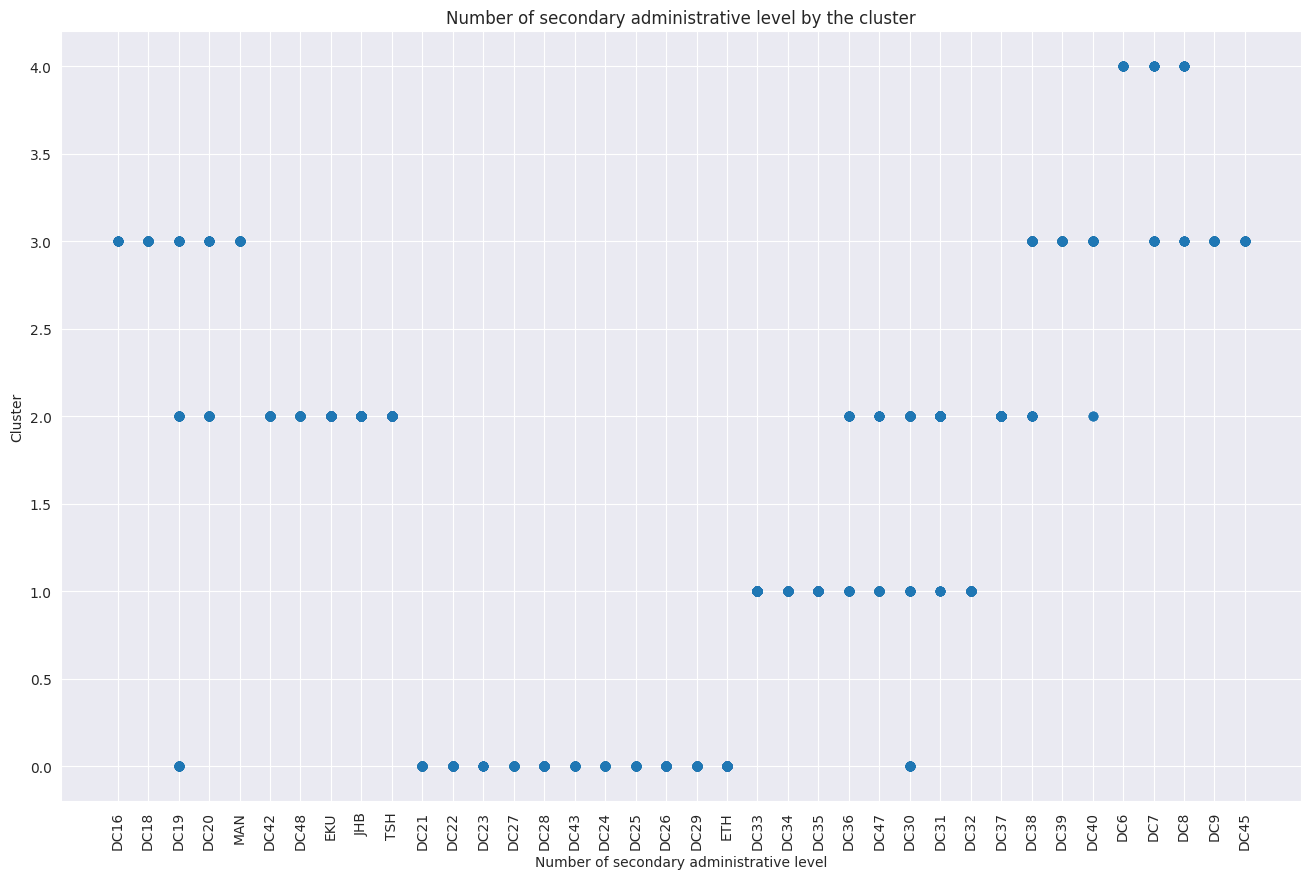

In [59]:
## Let's plot the number of secondary administrative level by the cluster
plt.scatter(eda_df["ADM2_ID"], eda_df["cluster"])
plt.title("Number of secondary administrative level by the cluster")
plt.xlabel("Number of secondary administrative level")
# Rotate the x-axis labels
plt.xticks(rotation=90)
plt.ylabel("Cluster")
plt.show()

- We can see that some regions is one cluster and others in two clusters. It's means that the cluster captures more information than just clustering by the secondary administrative level.

One of most important characteristics of poverty is the access to water. We will analyze the access to water by the cluster.

We will use the water access columns, and divide them in tree: the access to water is close to the house, the access to water is far from the house and the access to water is not available or unknown.

We will set as rural the regions with no access to water or with the access to water 70% times far from the house. We will set as urban the regions with the access to water close to the house.


In [115]:
close_water_cols = ["pw_00", "pw_01", "pw_02"]
far_water_cols = ["pw_03", "pw_04", "pw_05"]
no_water_cols = ["pw_06"]

eda_df["close_water"] = eda_df[close_water_cols].sum(axis=1)
eda_df["far_water"] = eda_df[far_water_cols].sum(axis=1)
eda_df["no_water"] = eda_df[no_water_cols].sum(axis=1)

eda_df["rural"] = False
eda_df.loc[(eda_df["no_water"] >= 0) & (eda_df["far_water"] >= 0.2), "rural"] = True

eda_df[["close_water", "far_water", "no_water", "rural"]].head()

,close_water,far_water,no_water,rural
0,0.976687,0.010385,0.012928,False
1,0.905084,0.090784,0.004131,False
2,0.889780,0.069339,0.040881,False
3,0.994320,0.000669,0.005011,False
4,0.975549,0.006822,0.017629,False


In [116]:
eda_df["rural"].value_counts()

rural
False    2506
True      316
Name: count, dtype: int64

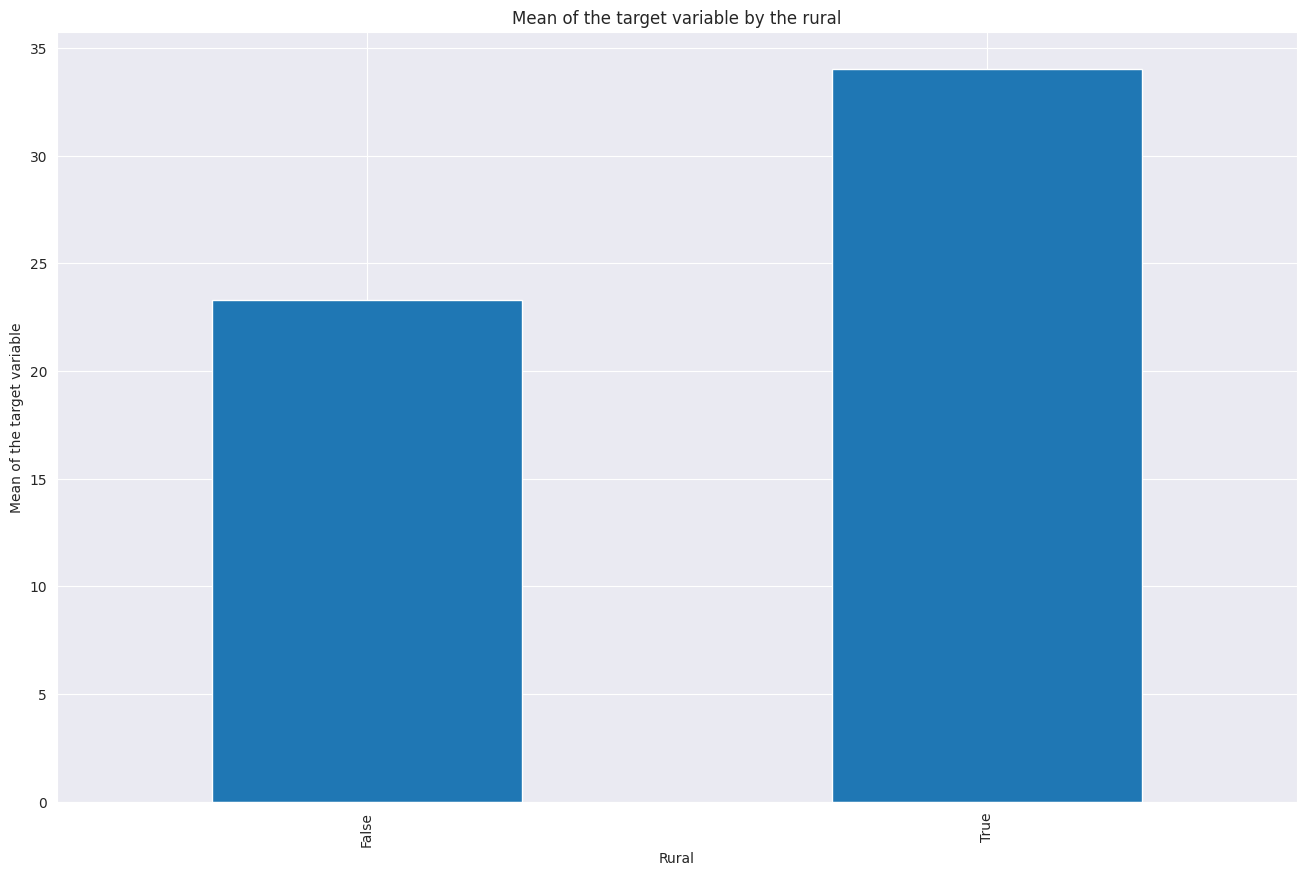

In [117]:
## Let's plot the water access with the target variable
eda_df.groupby("rural")["target"].mean().plot(kind="bar")
plt.title("Mean of the target variable by the rural")
plt.xlabel("Rural")
plt.ylabel("Mean of the target variable")
plt.show()

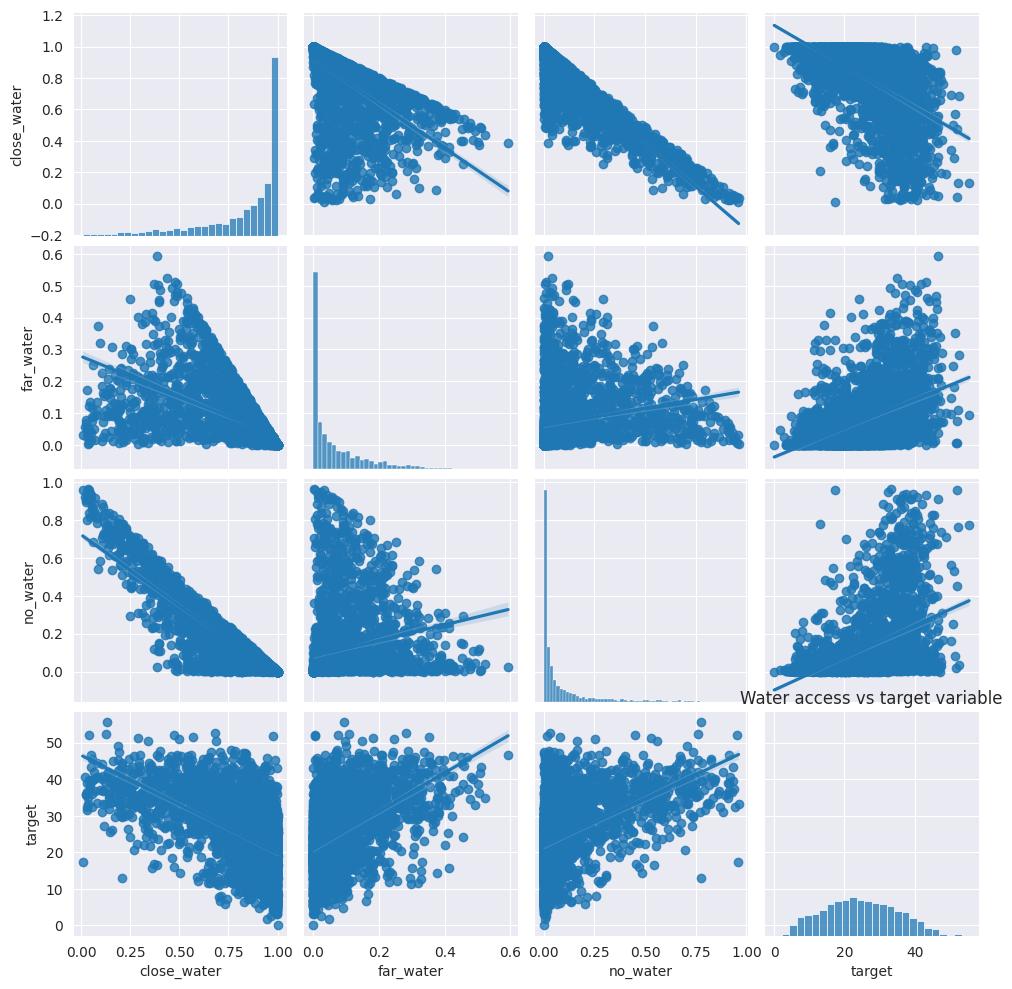

In [118]:
## Let's pairplot the new water access columns with the target variable
cols = ["close_water", "far_water", "no_water", "target"]
sns.pairplot(eda_df[cols], kind="reg")
plt.title(f"Water access vs target variable")
plt.show()

- As expected, the mean of the target variable is higher for the rural regions. It means that the access to water is an important feature to predict the target variable.
- We can see that there is a negative correlation between the target variable and the access to water close to the house. It means that the more close the water access, the less poverty.

Now, how can we accurately predict if a region is rural or urban? Let's try with a simple Gradient Boosting Classifier.
- We will use all other columns except the target variable and the water access columns.
- We will remove ADM2_ID and ADM3_ID because they are not the same in the train and test set.
- We will encode the cluster column.
- We will split the data in train, validation and test set.
- We will train the model with the train set and evaluate it with the validation set.
- We will plot the feature importance and some metrics.

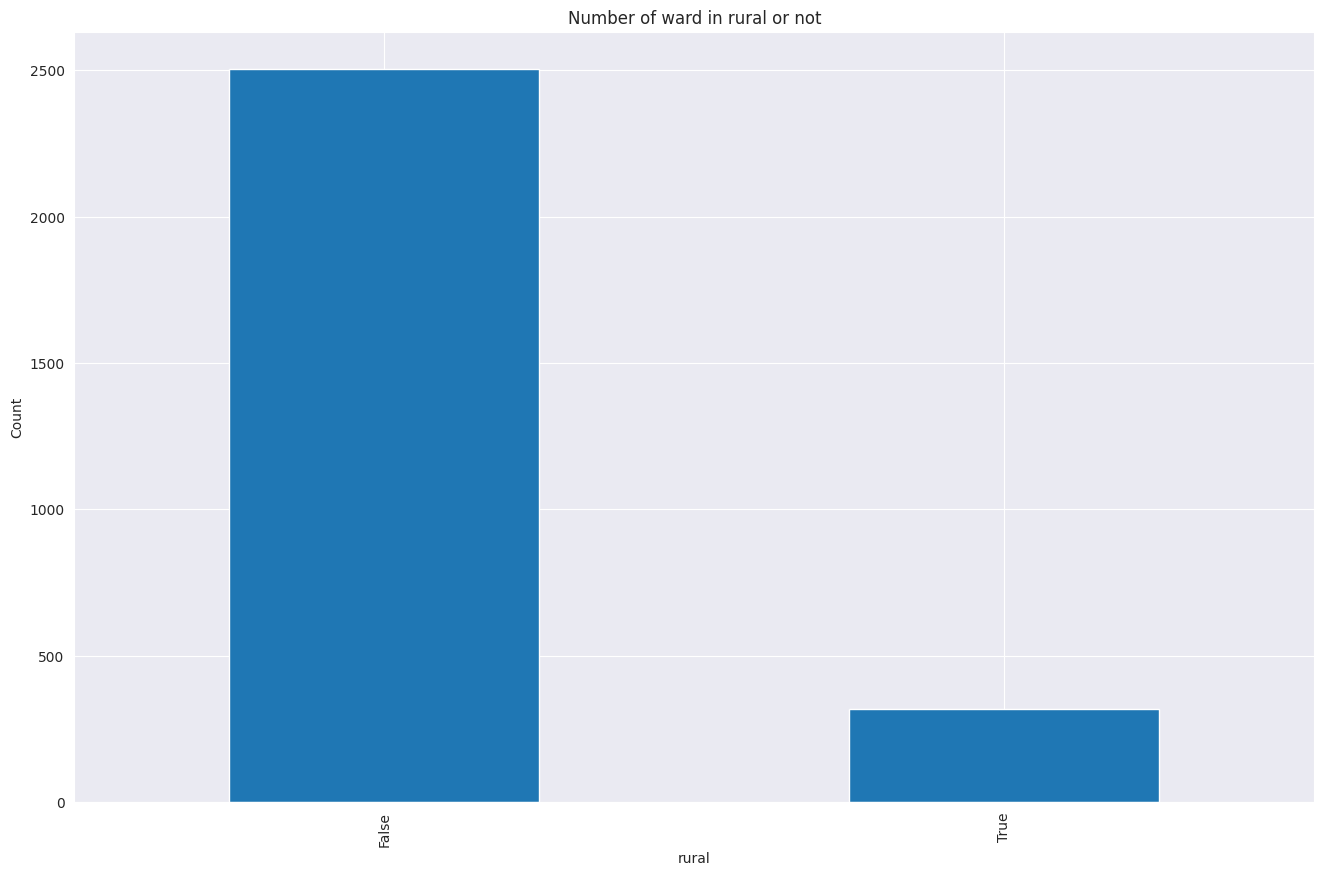

In [119]:
## Let's plot the distribution of the rural column
rural_count = eda_df["rural"].value_counts()
plt.title("Number of ward in rural or not")
plt.xlabel("Rural")
plt.ylabel("Count")
rural_count.plot(kind="bar")
plt.show()

We have a highly unbalanced dataset

In [127]:
## Let's prepare the data
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score, roc_curve, recall_score, roc_auc_score, precision_score
from sklearn.preprocessing import OneHotEncoder

pw_cols = [col for col in eda_df.columns if "pw_" in col]
drop_cols_1 = pw_cols + ["ADM2_ID", "ADM3_ID", "close_water", "far_water", "no_water", "ward", "ADM4_PCODE"]
drop_cols_2 = drop_cols_1 + ["target"]

## Encode the cluster column
encoder = OneHotEncoder()
encoded_cluster = encoder.fit_transform(eda_df[["cluster"]])
encoded_cluster_df = pd.DataFrame(encoded_cluster.toarray(), columns=encoder.get_feature_names_out(["cluster"]))

ft_columns = drop_cols_1 + ["rural", "cluster", "cluster_0"] # We will remove one cluster column
X = pd.concat([eda_df, encoded_cluster_df], axis=1).drop(ft_columns , axis=1)
y = eda_df["rural"]

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, shuffle=True, stratify=y)
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.2, stratify=y_train)

In [128]:
X.columns

Index(['total_households', 'total_individuals', 'target', 'dw_00', 'dw_01',
       'dw_02', 'dw_03', 'dw_04', 'dw_05', 'dw_06', 'dw_07', 'dw_08', 'dw_09',
       'dw_10', 'dw_11', 'psa_00', 'psa_01', 'psa_02', 'psa_03', 'psa_04',
       'stv_00', 'stv_01', 'car_00', 'car_01', 'lln_00', 'lln_01', 'lan_00',
       'lan_01', 'lan_02', 'lan_03', 'lan_04', 'lan_05', 'lan_06', 'lan_07',
       'lan_08', 'lan_09', 'lan_10', 'lan_11', 'lan_12', 'lan_14', 'pg_00',
       'pg_01', 'pg_02', 'pg_03', 'pg_04', 'lgt_00', 'lat', 'lon', 'NL',
       'AREA_SQKM', 'cluster_1', 'cluster_2', 'cluster_3', 'cluster_4'],
      dtype='object')

In [129]:
## Let's train the model
gbt = GradientBoostingClassifier(random_state=42)
gbt.fit(X_train, y_train)

GradientBoostingClassifier(random_state=42)

In [130]:
## Let's evaluate the model
y_pred = gbt.predict(X_val)
accuracy = accuracy_score(y_val, y_pred)
recall = recall_score(y_val, y_pred)
precision = precision_score(y_val, y_pred)
roc_auc = roc_auc_score(y_val, y_pred)

print(f"Accuracy: {accuracy:.2f}")
print(f"Recall: {recall:.2f}")
print(f"Precision: {precision:.2f}")
print(f"ROC AUC: {roc_auc:.2f}")


Accuracy: 0.89
Recall: 0.29
Precision: 0.55
ROC AUC: 0.63


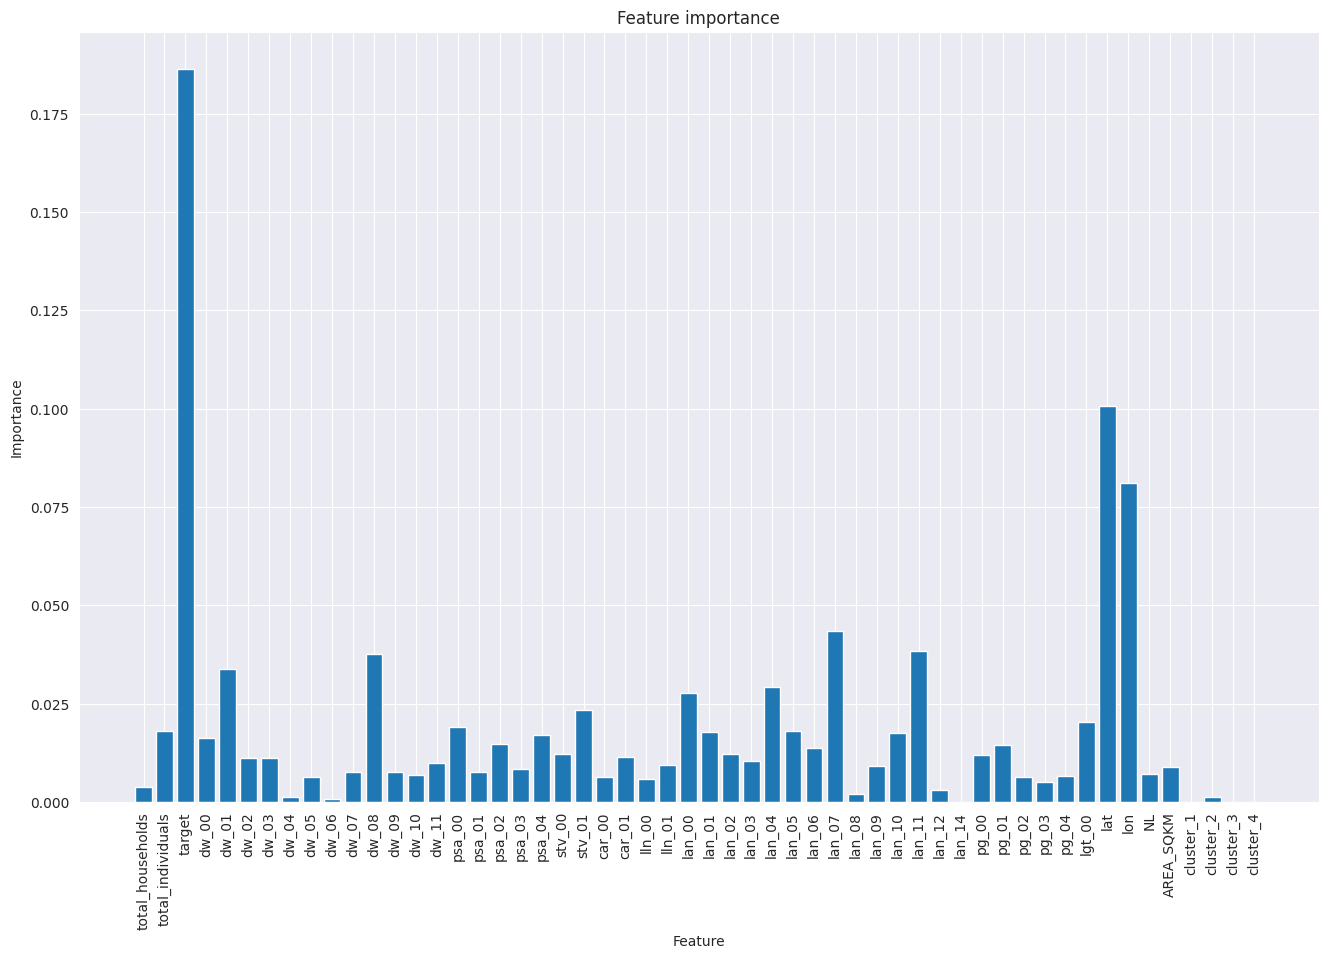

In [131]:
## Let's plot the feature importance
feature_importance = gbt.feature_importances_
plt.bar(X.columns, feature_importance)
plt.xticks(rotation=90)
plt.title("Feature importance")
plt.xlabel("Feature")
plt.ylabel("Importance")
plt.show()

In [132]:
## Let's evaluate the model with the test set
y_pred = gbt.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred)

print(f"Accuracy: {accuracy:.2f}")
print(f"Recall: {recall:.2f}")
print(f"Precision: {precision:.2f}")
print(f"ROC AUC: {roc_auc:.2f}")

Accuracy: 0.90
Recall: 0.37
Precision: 0.56
ROC AUC: 0.67


- We can see that the target column of the original set is the most important feature. Followed by the location, the language and the Dw.
- The recall and f1 score are low on the test set, meaning that the model is not highly accurate

Accuracy: 0.90
Recall: 0.27
Precision: 0.65
ROC AUC: 0.63
Accuracy: 0.89
Recall: 0.24
Precision: 0.55
ROC AUC: 0.61


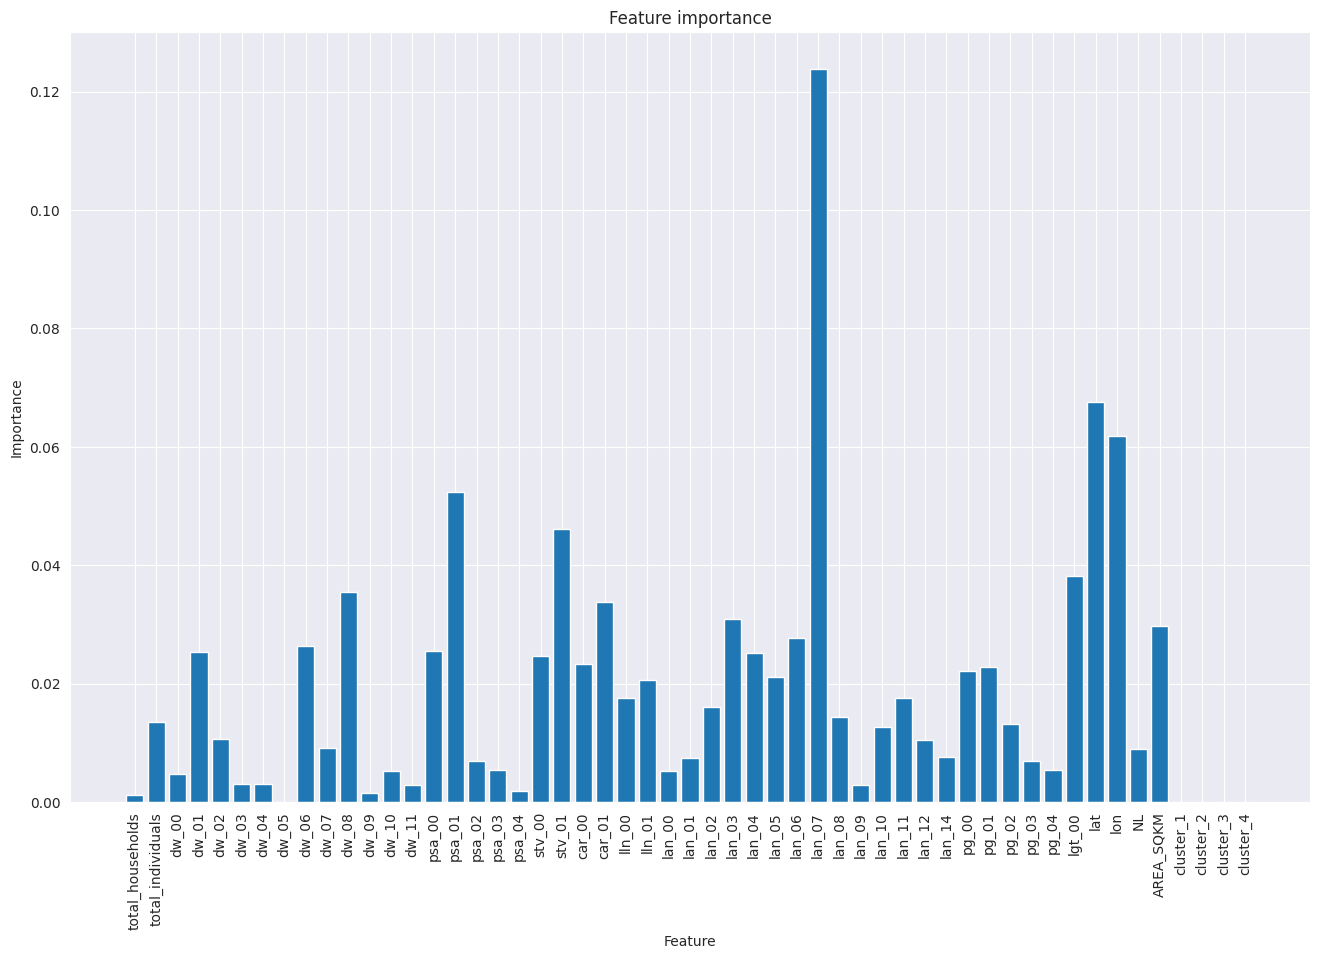

In [134]:
## Let's try without the target column
encoder = OneHotEncoder()
encoded_cluster = encoder.fit_transform(eda_df[["cluster"]])
encoded_cluster_df = pd.DataFrame(encoded_cluster.toarray(), columns=encoder.get_feature_names_out(["cluster"]))

ft_columns = drop_cols_2 + ["rural", "cluster", "cluster_0"] # We will remove one cluster column
X = pd.concat([eda_df, encoded_cluster_df], axis=1).drop(ft_columns , axis=1)
y = eda_df["rural"]

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, shuffle=True, stratify=y)
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.2, stratify=y_train)

gbt = GradientBoostingClassifier(random_state=42)
gbt.fit(X_train, y_train)

## Let's evaluate the model
y_pred = gbt.predict(X_val)
accuracy = accuracy_score(y_val, y_pred)
recall = recall_score(y_val, y_pred)
precision = precision_score(y_val, y_pred)
roc_auc = roc_auc_score(y_val, y_pred)

print(f"Accuracy: {accuracy:.2f}")
print(f"Recall: {recall:.2f}")
print(f"Precision: {precision:.2f}")
print(f"ROC AUC: {roc_auc:.2f}")

## Let's evaluate the model with the test set
y_pred = gbt.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred)

print(f"Accuracy: {accuracy:.2f}")
print(f"Recall: {recall:.2f}")
print(f"Precision: {precision:.2f}")
print(f"ROC AUC: {roc_auc:.2f}")

## Let's plot the feature importance
feature_importance = gbt.feature_importances_
plt.bar(X.columns, feature_importance)
plt.xticks(rotation=90)
plt.title("Feature importance")
plt.xlabel("Feature")
plt.ylabel("Importance")
plt.show()

As expected, the model perform worst than with the target column, it highlighted the importance of enrich our dataset to have a more accurate model.